<a href="https://colab.research.google.com/github/2100030074/Indian-Food-Classification-/blob/main/Indian_Food_Classification_using_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Dependencies
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from PIL import Image
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from skimage.io import imread

K.clear_session()

In [ ]:
img = plt.imread('/content/drive/MyDrive/Colab Notebooks/Food Classification/pizza/033.jpg')
dims = np.shape(img)
dims

(619, 1100, 3)

In [ ]:
matrix = np.reshape(img , (dims[0] * dims[1] , dims[2]))
print(np.shape(matrix))

(680900, 3)


Image Shape:- (619, 1100)
Color Channels:- 3
Min Color Depth : 0, Max Color Depth 255


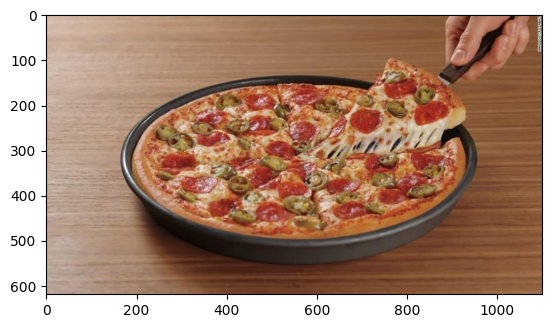

In [ ]:
plt.imshow(img)
print("Image Shape:-" , dims[:2])
print("Color Channels:-", dims[2])
print("Min Color Depth : {}, Max Color Depth {}".format(np.min(img) , np.max(img)))

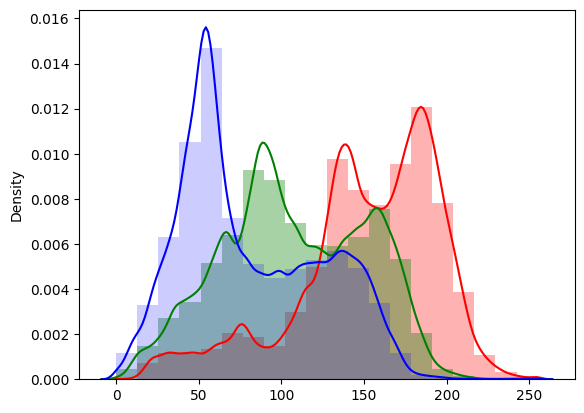

In [ ]:
sns.distplot(matrix[:,0], bins=20,color="red",hist_kws=dict(alpha=0.3))
sns.distplot(matrix[:,1], bins=20,color="green",hist_kws=dict(alpha=0.35))
sns.distplot(matrix[:,2], bins=20,color="blue",hist_kws=dict(alpha=0.2))
plt.show()

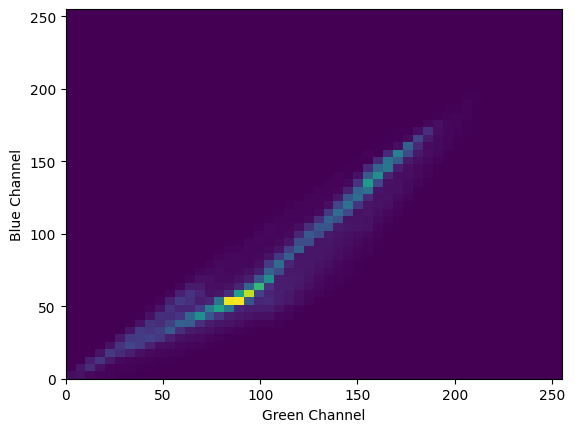

In [ ]:
_ = plt.hist2d(matrix[:,1] , matrix[:,2] , bins = (50,50))
plt.xlabel("Green Channel")
plt.ylabel("Blue Channel")
plt.show()

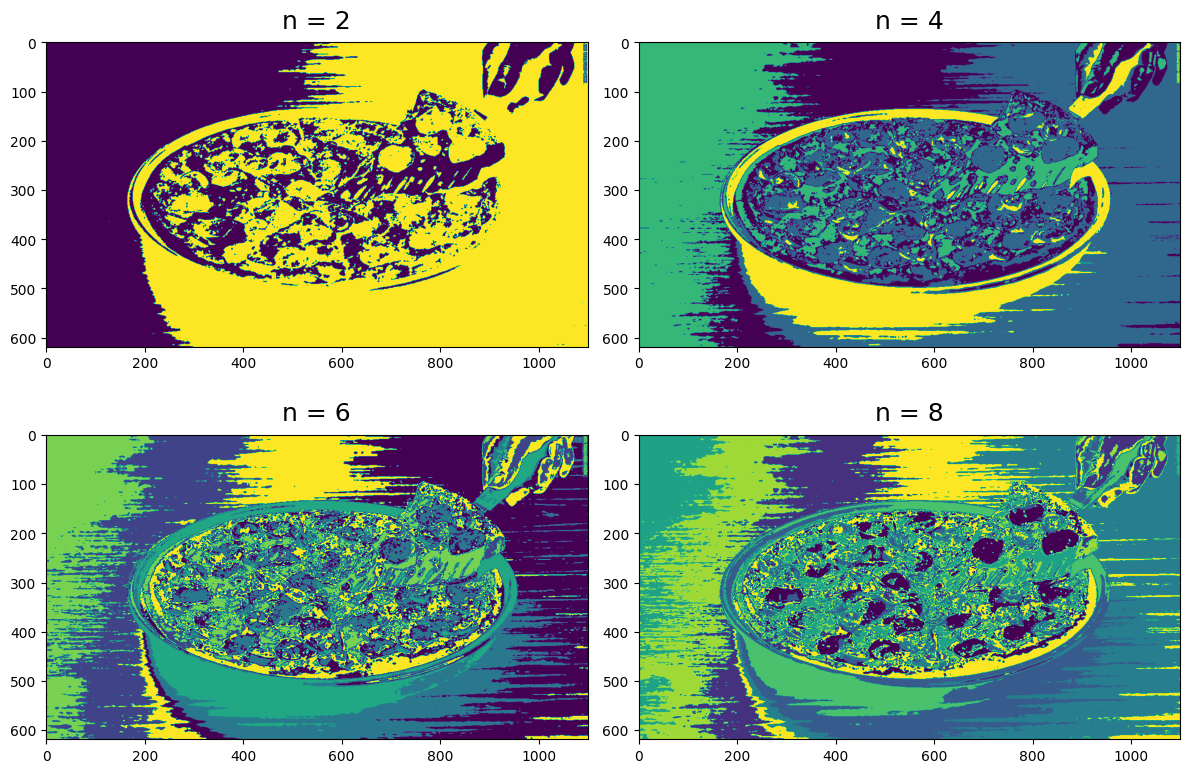

In [ ]:
from sklearn import cluster
n_vals = [2,4,6,8]
plt.figure(1 , figsize = (12 , 8))

for subplot , n in enumerate(n_vals):
    kmeans = cluster.KMeans(n)
    clustered = kmeans.fit_predict(matrix)
    dims = np.shape(img)
    clustered_img = np.reshape(clustered , (dims[0] , dims[1]))
    plt.subplot(2,2, subplot+1)
    plt.title("n = {}".format(n) , pad = 10 , size = 18)
    plt.imshow(clustered_img)

plt.tight_layout()

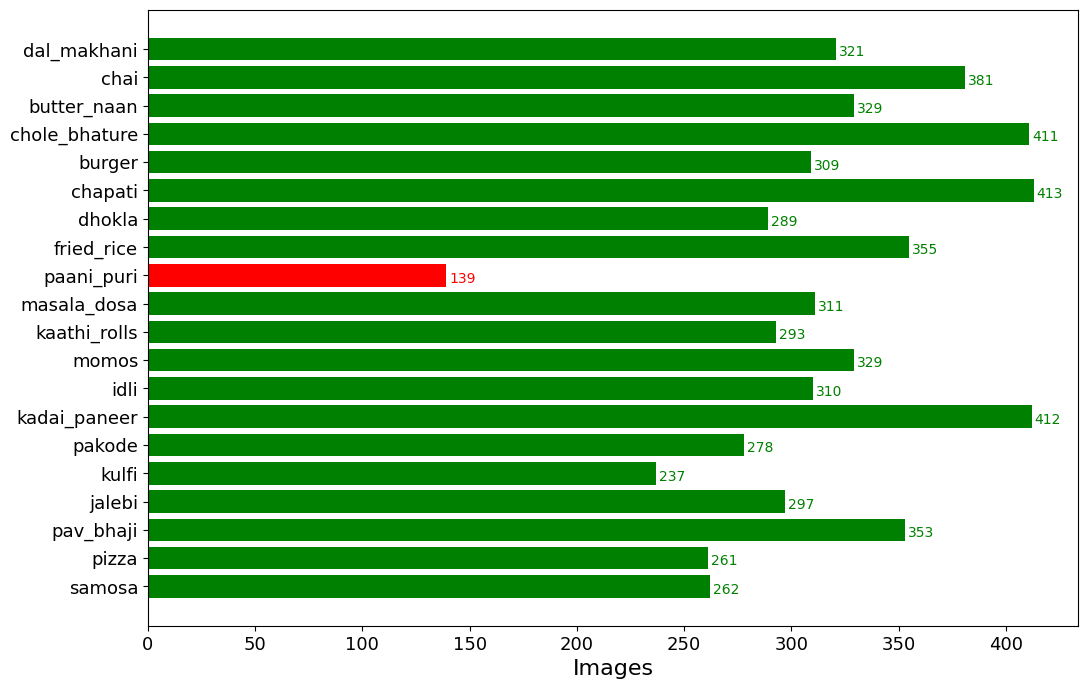

In [ ]:
import os

train = '/content/drive/MyDrive/Colab Notebooks/Food Classification/train'

data = dict()

for i in os.listdir(train):
    sub_dir = os.path.join(train , i)
    count = len(os.listdir(sub_dir))
    data[i] = count

keys = data.keys()
values = data.values()

colors = ["red" if x<= 150 else "green" for x in values]

fig , ax = plt.subplots(figsize = (12,8))
y_pos = np.arange(len(values))
plt.barh(y_pos , values , align = "center" , color=colors)
for i , v in enumerate(values):
    ax.text(v+1.4 , i-0.25 , str(v), color = colors[i])
ax.set_yticks(y_pos)
ax.set_yticklabels(keys)
ax.set_xlabel('Images',fontsize=16)
plt.xticks(color='black',fontsize=13)
plt.yticks(fontsize=13)
plt.show()

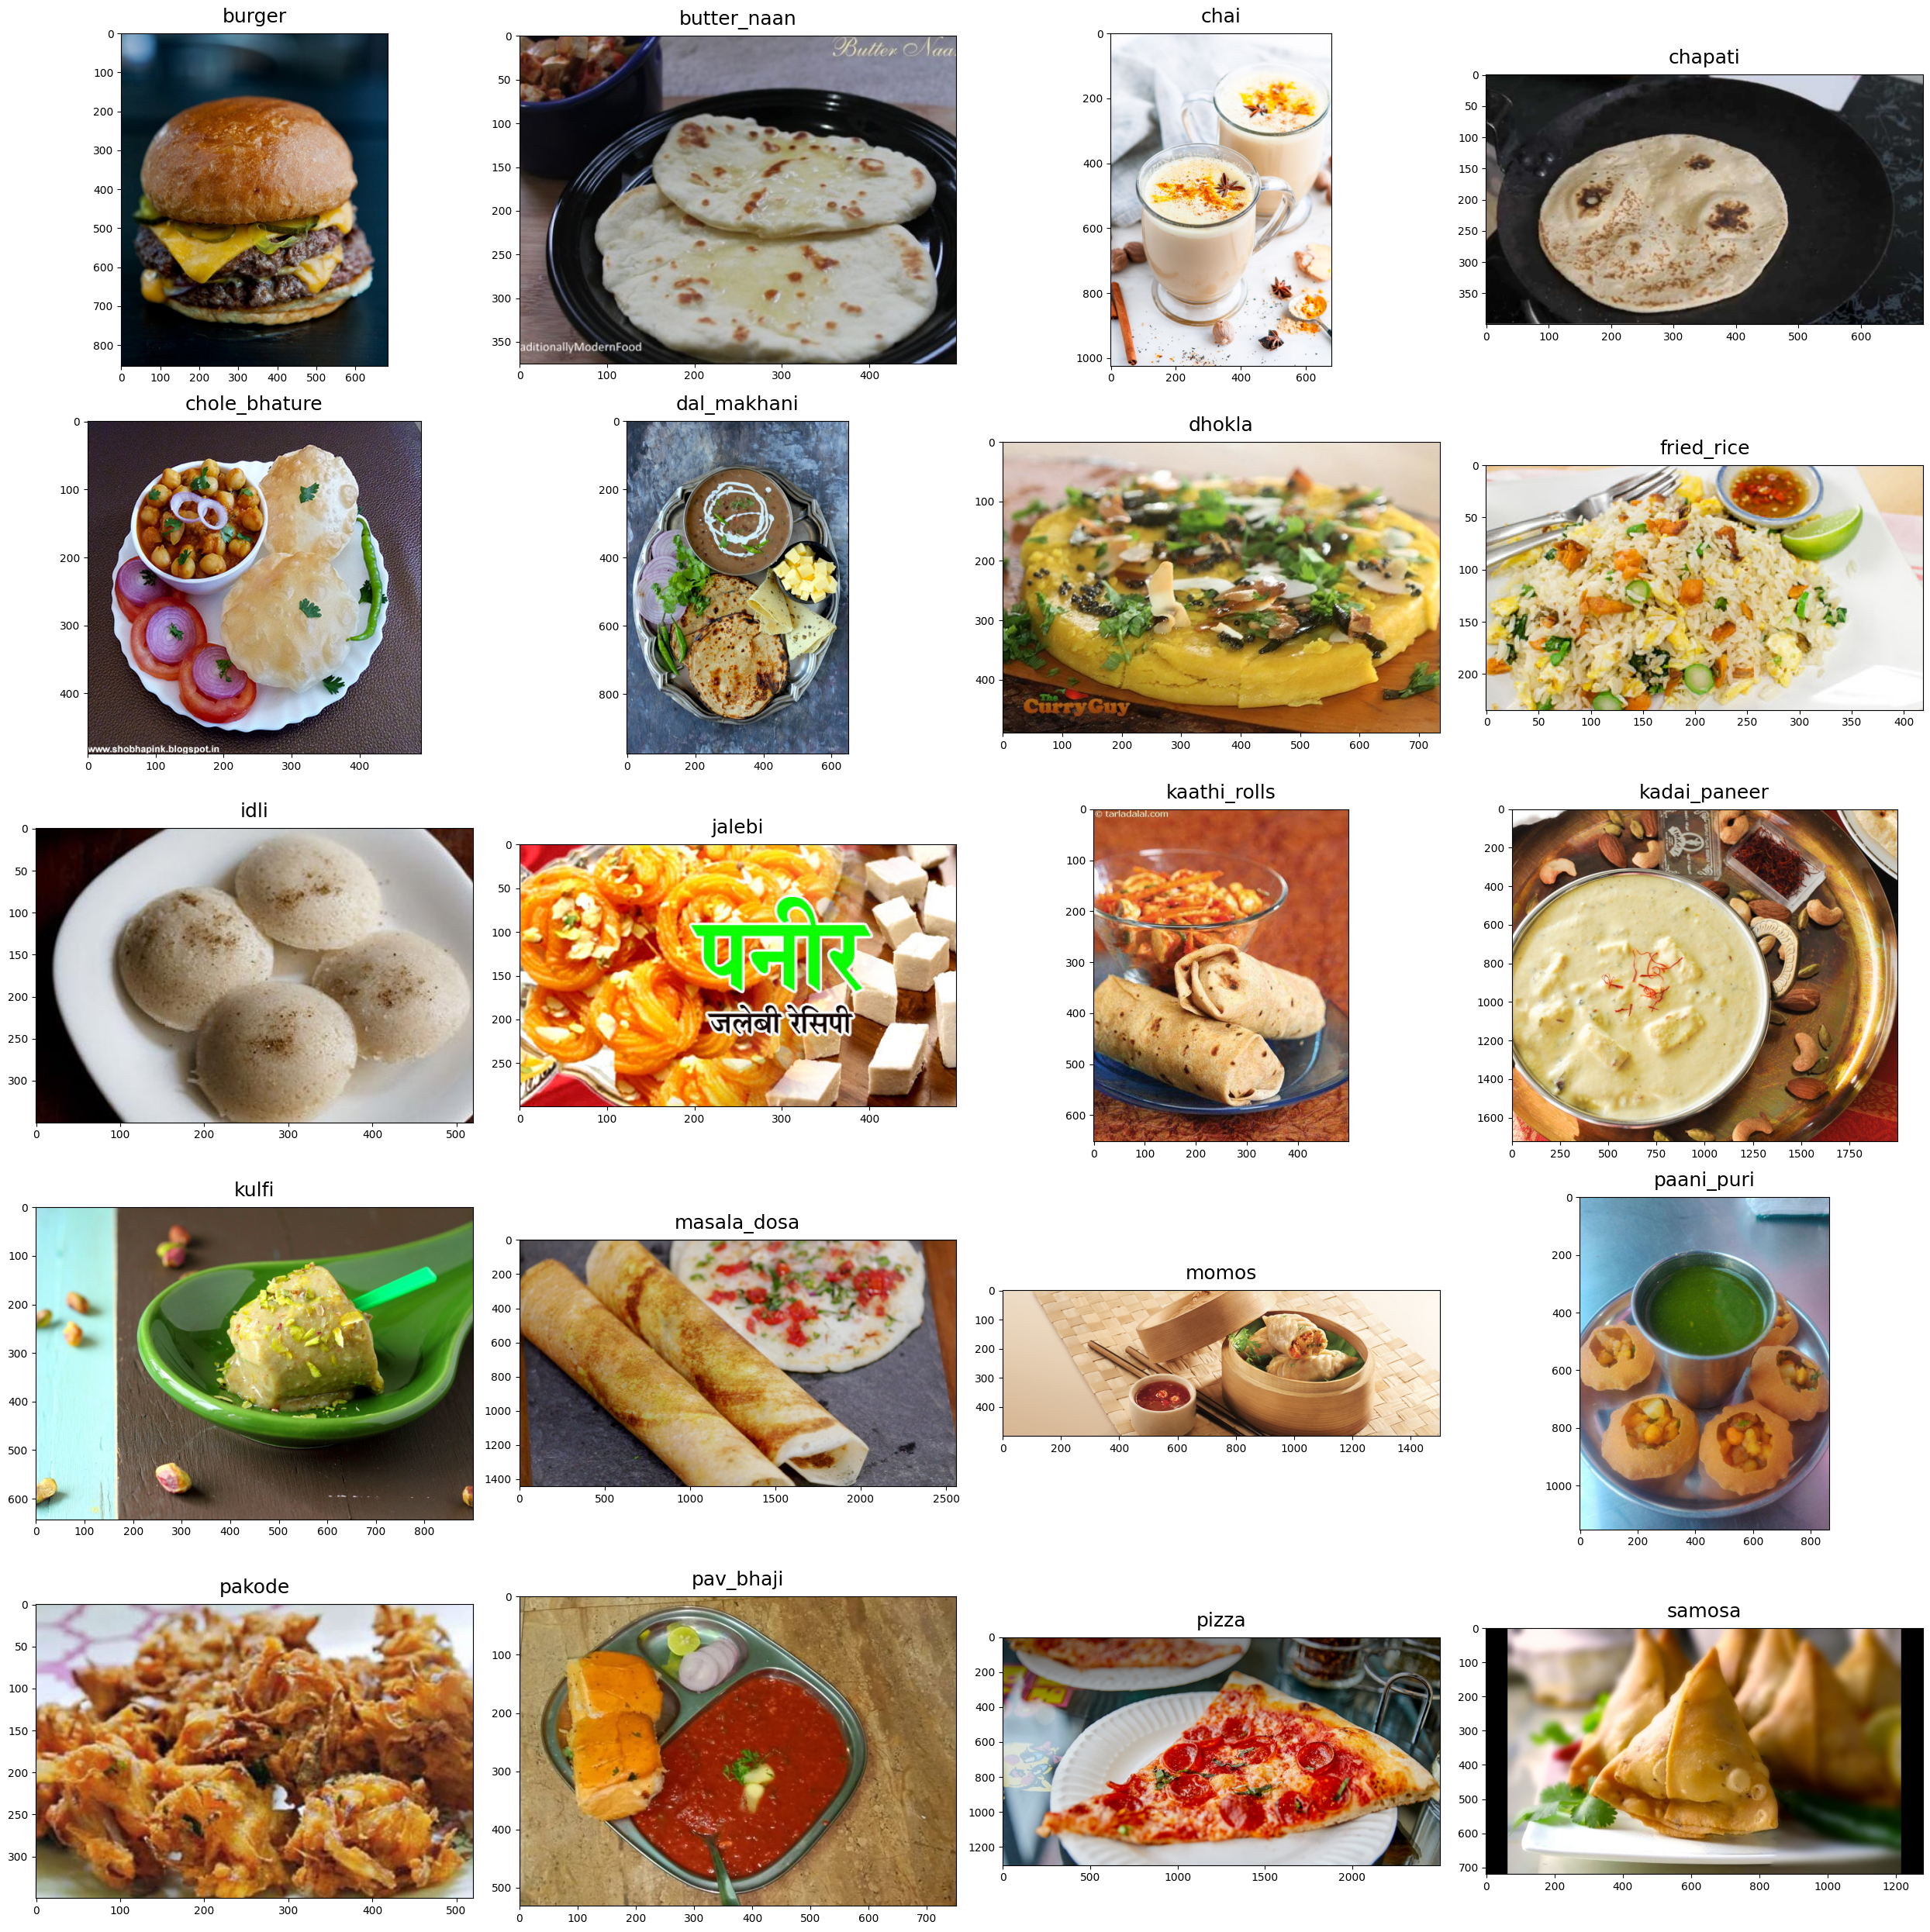

In [ ]:
import random

train_folder = "/content/drive/MyDrive/Colab Notebooks/Food Classification/train"
images = []

for food_folder in sorted(os.listdir(train_folder)):
    food_items = os.listdir(train_folder + "/" + food_folder)
    food_selected = np.random.choice(food_items)
    images.append(os.path.join(train_folder , food_folder , food_selected))


fig = plt.figure(1 , figsize = (25,25))
for subplot , image_ in enumerate(images):
    category = image_.split("/")[-2]
    imgs = plt.imread(image_)
    a ,b, c = imgs.shape
    fig = plt.subplot(5 , 4 , subplot+1)
    fig.set_title(category , pad = 10 , size = 18)
    plt.imshow(imgs)

plt.tight_layout()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

n_classes = 20
batch_size = 32
img_width , img_height = 299 , 299

train_data_dir = '/content/drive/MyDrive/Colab Notebooks/Food Classification/train'

# Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)


val_data_dir = '/content/drive/MyDrive/Colab Notebooks/Food Classification/val'
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 6288 images belonging to 20 classes.
Found 6269 images belonging to 20 classes.


In [ ]:
class_map = train_generator.class_indices
class_map

{'burger': 0,
 'butter_naan': 1,
 'chai': 2,
 'chapati': 3,
 'chole_bhature': 4,
 'dal_makhani': 5,
 'dhokla': 6,
 'fried_rice': 7,
 'idli': 8,
 'jalebi': 9,
 'kaathi_rolls': 10,
 'kadai_paneer': 11,
 'kulfi': 12,
 'masala_dosa': 13,
 'momos': 14,
 'paani_puri': 15,
 'pakode': 16,
 'pav_bhaji': 17,
 'pizza': 18,
 'samosa': 19}

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

nb_train_samples = 3583
nb_valid_samples = 1089

image_size = [299 , 299]

inception = InceptionV3(input_shape = image_size + [3] , weights = "imagenet" , include_top = False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128 , activation = "relu")(x)
x = Dropout(0.2)(x)

predictions = Dense(n_classes , kernel_regularizer = l2(0.005) , activation = "softmax")(x)

model = Model(inputs = inception.input , outputs = predictions)
model.compile(optimizer = SGD(lr=0.0001 , momentum = 0.9) , loss = "categorical_crossentropy" , metrics = ["accuracy"])

checkpoints = ModelCheckpoint(filepath = "v1_inceptionV3" , verbose = 1 , save_best_only = True)
csv_logger = CSVLogger("history_v1_inceptionV3.log")

history = model.fit_generator(train_generator,
                             steps_per_epoch = nb_train_samples // batch_size,
                             validation_data = val_generator,
                             validation_steps = nb_valid_samples // batch_size,
                             epochs = 20,
                             verbose = 1,
                             callbacks = [csv_logger , checkpoints])

87910968/87910968 [==============================] - 3s 0us/step


Epoch 1/20
111/111 [==============================] - ETA: 0s - loss: 1.4770 - accuracy: 0.6360 